In [25]:
import numpy as np
import matplotlib.pyplot as plt

def LoadBatch(filename):
    """ Copied from the dataset website """
    import pickle
    with open('datasets/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1') #encoding='latin1' is required for unpickling NumPy arrays
    return dict

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

def normalize(x, mean, std):
    return (x-mean)/std

def EvaluateClassifier(X, W, b):
    s = (W @ X.T) + b
    p = softmax(s)    
    return p

def softmax(x):
    """ Standard definition of code """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def ComputeCost(X,Y,W,b,lamda):
    p = EvaluateClassifier(X, W, b)
    lcross = -Y.T*np.log(p)
    cost = (1/X.shape[0]) * (np.sum(lcross) + (lamda * np.sum(W**2)))
    return cost

def ComputeAccuracy(X, Y, W, b):
    p = EvaluateClassifier(X, W, b)
    max_idx = np.argmax(p, axis=0)
    acc = np.count_nonzero((Y - max_idx)==0)/X.shape[0]
    return acc

def ComputeGradients(X, Y, W, b, lamda):
    P = EvaluateClassifier(X, W, b)
    grad_batch = -(Y.T - P)
    grad_W = 1/X.shape[0]*(grad_batch @ X) + 2*lamda*W
    grad_b = np.reshape(1/X.shape[0]*(grad_batch @ np.ones(X.shape[0])), (Y.shape[1], 1))
    return [grad_W, grad_b]
    
def ComputeGradsNum(X, Y, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    c = ComputeCost(X, Y, W, b, lamda);

    for i in range(len(b)):
        print(i)
        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        print(i)
        for j in range(W.shape[1]):
            W_try = W
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)
            grad_W[i,j] = (c2-c) / h

    return [grad_W, grad_b]

def ComputeGradsNumSlow(X, Y, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = ComputeCost(X, Y, W, b_try, lamda)

        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)

        grad_b[i] = (c2-c1) / (2*h)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] -= h
            c1 = ComputeCost(X, Y, W_try, b, lamda)

            W_try = np.array(W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)

            grad_W[i,j] = (c2-c1) / (2*h)

    return [grad_W, grad_b]

def montage(W):
    """ Display the image for each label in W """
    fig, ax = plt.subplots(2,5)
    for i in range(2):
        for j in range(5):
            im = W [5 * i + j,:].reshape (32,32,3, order = 'F')
            sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
            sim = sim.transpose(1,0,2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].set_title("y="+str(5*i+j))
            ax[i][j].axis('off')
    plt.show()

def mini_batch_gd(n, n_batch, X_train, Y_train, X_train_val, Y_train_val, Y_trn, Y_val, eta, n_epochs, W, b, lamda):
    w_star = W
    b_star = b
    cost_train = []
    cost_val = []
    accuracy_train = []
    accuracy_val = []
    for epoch in range(n_epochs):
        if (epoch+1)%10 == 0:
                print('Epoch' + str(epoch+1))
        X_batch = np.zeros((n_batch, X_train.shape[1]))
        Y_batch = np.zeros((n_batch, Y_train.shape[1]))
        for j in range(1, int(n/n_batch)):
            start_idx = (j-1)*n_batch
            end_idx = j*n_batch
            X_batch = X_train[start_idx:end_idx, :]
            Y_batch = Y_train[start_idx:end_idx, :]
            X_batch_val = X_train_val[start_idx:end_idx, :]
            Y_batch_val = Y_train_val[start_idx:end_idx, :]
            Y_trn_batch = Y_trn[start_idx:end_idx]
            Y_val_batch = Y_val[start_idx:end_idx]
            grad_w, grad_b = ComputeGradients(X_batch, Y_batch, w_star, b_star, lamda)
            w_star -= eta * grad_w
            b_star -= eta * grad_b
        cost_train.append(ComputeCost(X_batch, Y_batch, w_star, b_star, lamda))
        cost_val.append(ComputeCost(X_batch_val, Y_batch_val, w_star, b_star, lamda))
        accuracy_train.append(ComputeAccuracy(X_batch, Y_trn_batch, w_star, b_star))
        accuracy_val.append(ComputeAccuracy(X_batch_val, Y_val_batch, w_star, b_star))
    plot_performance(cost_train, cost_val, n_epochs, 'cost')
    plot_performance(accuracy_train, accuracy_val, n_epochs, 'acc')
    return w_star, b_star

def plot_performance(train_data, val_data, n_epochs, plot_type):
    if plot_type == 'cost':
        plt.title('Cost Fucntion')
    elif plot_type == 'acc':
        plt.title('Accuracy')
    plt.xlim(0, n_epochs)
    plt.plot(train_data, label = "Training data")
    plt.plot(val_data, label = "Validation data")
    plt.legend()
    #plt.savefig('result_pics/' + plot_type + '.png')
    plt.show()

Epoch10
Epoch20
Epoch30
Epoch40


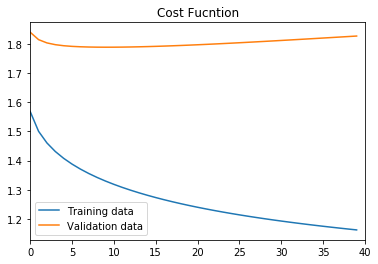

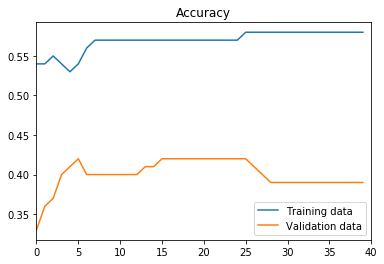

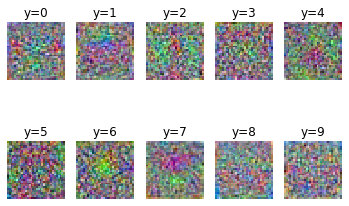

Accuracy on training data: 0.516
Accuracy on validation data: 0.3515
Accuracy on test data: 0.3579


In [28]:
#load image data 
image_data_training = LoadBatch('data_batch_1')
image_data_validation = LoadBatch('data_batch_2')
image_data_test = LoadBatch('test_batch')

#Training data
X_train = image_data_training['data']
Y_train_one_hot = one_hot_encode(image_data_training['labels'])
Y_train = image_data_training['labels']

#Validation data
X_val = image_data_validation['data']
Y_val_one_hot = one_hot_encode(image_data_validation['labels'])
Y_val = image_data_validation['labels']

#Test data
X_test = image_data_test['data']
Y_test = image_data_test['labels']

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

#Normalized data
img_trn_nrm = normalize(X_train, mean, std)
img_val_nrm = normalize(X_val, mean, std)
img_test_nrm = normalize(X_test, mean, std)


W = np.random.normal(0, 0.01, (10, img_val_nrm.shape[1]))
b = np.random.normal(0, 0.01, (10, 1))

n_batch = 100
eta = 0.01
n_epochs = 40
lamda = 0
total_samples = img_trn_nrm.shape[0]
#Training and Validation
w_star, b_star = mini_batch_gd(total_samples, n_batch, img_trn_nrm, Y_train_one_hot, img_val_nrm, Y_val_one_hot,
                                          Y_train, Y_val, eta, n_epochs, W, b, lamda)
#show image
montage(w_star)

#Accuracy
train_acc = ComputeAccuracy(img_trn_nrm, Y_train, w_star, b_star)
print('Accuracy on training data: ' + str(train_acc))
val_acc = ComputeAccuracy(img_val_nrm, Y_val, w_star, b_star)
print('Accuracy on validation data: ' + str(val_acc))
test_acc = ComputeAccuracy(img_test_nrm, Y_test, w_star, b_star)
print('Accuracy on test data: ' + str(test_acc))

